<a href="https://colab.research.google.com/github/thspanos/AI-LAb/blob/main/Thomas_Spanos_Tor_Hunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
# Κωδικοποίηση Label-1 σε 0,1,2,...
df['Label-1_code'], label1_uniques = pd.factorize(df['Label-1'])
label1_map = {cat: int(idx) for idx, cat in enumerate(label1_uniques)}

# Κωδικοποίηση Label-2 σε 0,1,2,...
df['Label-2_code'], label2_uniques = pd.factorize(df['Label-2'])
label2_map = {cat: int(idx) for idx, cat in enumerate(label2_uniques)}


    TARGET_COL = 'Label-1_code'
# κρατάμε μόνο τις αριθμητικές στήλες
    X = df.select_dtypes(include=['number']).drop(columns=[TARGET_COL], errors='ignore').values
    y = df[TARGET_COL].values
 #   X = df.drop('target', axis=1).values
  #  y = df['target'].values
    return X, y

In [4]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [6]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

# --- IPS block
       #         y_pred = np.argmax(model.predict(X_test), axis=1)   # (N,)
        #        blocked_indices = np.where(y_pred == 2)[0]
         #       if blocked_indices.size > 0:
          #          print(f"Blocking {len(blocked_indices)} malicious traffic instances.")
# --- IPS block ---


                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

In [7]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/thspanos/AI-LAb/refs/heads/main/Data/DarkNet.csv'

In [8]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [9]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

/tmp/ipython-input-3229902208.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


KeyError: 'Label-1_code'

In [ ]:
# Load the dataset to inspect column names
temp_df = pd.read_csv(csv_file_path)
print(temp_df.columns)

In [ ]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6410 - loss: 0.8088
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8491 - loss: 0.4959
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8757 - loss: 0.4374
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8873 - loss: 0.4166
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8838 - loss: 0.4222
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
Blocking 1019 malicious traffic instances.
Batch 800, Training Accuracy: 0.9145, Test Accuracy: 0.9021
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6401 - loss: 0.7995
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8452 - loss: 0.4884
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8753 - loss: 0.4417
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8806 - loss: 0.4362
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8922 - loss: 0.4021
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
Blocking 1000 malicious traffic instances.
Batch 1600, Training Accuracy: 0.9153, Test Accuracy: 0.9048
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6358 - loss: 0.8044
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8493 - loss: 0.4942
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8743 - loss: 0.4328
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8808 - loss: 0.4282
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9004 - loss: 0.3925
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
Blocking 1013 malicious traffic instances.
Batch 2400, Training Accuracy: 0.9174, Test Accuracy: 0.9035
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6446 - loss: 0.7997
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8452 - loss: 0.5022
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8689 - loss: 0.4548
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8867 - loss: 0.4187
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8898 - loss: 0.4099
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1015 malicious traffic instances.
Batch 3200, Training Accuracy: 0.9136, Test Accuracy: 0.9031
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6366 - loss: 0.8049
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8427 - loss: 0.5098
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8670 - loss: 0.4589
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.4230
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8935 - loss: 0.4027
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
Blocking 1000 malicious traffic instances.
Batch 4000, Training Accuracy: 0.9162, Test Accuracy: 0.9018
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6447 - loss: 0.8086
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8457 - loss: 0.5037
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8815 - loss: 0.4177
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8792 - loss: 0.4384
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.4129
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
Blocking 1005 malicious traffic instances.
Batch 4800, Training Accuracy: 0.9146, Test Accuracy: 0.9058
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6399 - loss: 0.8092
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8426 - loss: 0.5039
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8672 - loss: 0.4521
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8837 - loss: 0.4186
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8856 - loss: 0.4136
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
Blocking 1004 malicious traffic instances.
Batch 5600, Training Accuracy: 0.9146, Test Accuracy: 0.9021
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6359 - loss: 0.8101
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8480 - loss: 0.4955
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8690 - loss: 0.4554
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8874 - loss: 0.4187
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8873 - loss: 0.4076
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
Blocking 1004 malicious traffic instances.
Batch 6400, Training Accuracy: 0.9154, Test Accuracy: 0.9041
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6133 - loss: 0.8515
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.4837
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8758 - loss: 0.4486
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8880 - loss: 0.4165
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8967 - loss: 0.3964
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Blocking 1006 malicious traffic instances.
Batch 7200, Training Accuracy: 0.9147, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6355 - loss: 0.8098
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8492 - loss: 0.4829
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8716 - loss: 0.4601
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8790 - loss: 0.4407
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8904 - loss: 0.4088
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
Blocking 1005 malicious traffic instances.
Batch 8000, Training Accuracy: 0.9144, Test Accuracy: 0.9055


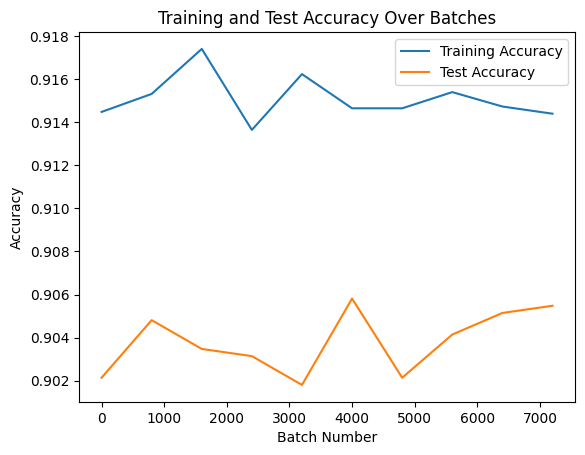

In [ ]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)